
<img src="../images/starwarsstartrek.png" style="float: center; margin: 0px; height: 150px; width: 500px"> 

## SUBREDDIT CLASSIFIER

###### _Author: Afolabi Cardoso_

---

### Pre-Processing and Logistic Regression modelling

---
#### Contents:
[Overview](#Overview) | [Imports](#Imports) | [Modeling](#Modeling) | [Model evaluation](#Model-evaluation)


---
#### Overview

In this notebook, I will be using logistic regression to classify the dataset.


---

#### Imports

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [63]:
df = pd.read_csv('../data/preprocessed.csv')
df.head()

,title,selftext,created_utc,subreddit,mood
0,wars game,,1646329318,1,-0.5574
1,if a wars game about the famous wars in comics,,1646329234,1,-0.8020
2,what makes a wars fan a fan,,1646329180,1,0.0000
3,what makes a wars fan,,1646328985,1,-0.3182
4,random clone wars thoughts,the series makes me appreciate anakin so much ...,1646328915,1,-0.5574


#### Modeling

#### Logistic regression model

Define our X, y

In [65]:
X = df['title']
y = df['subreddit']

#### Train/Test/Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [67]:
y.isna().sum()

0

#### Baseline accuracy score

In [69]:
baseline = y_train.value_counts(normalize=True)
baseline

0    0.504667
1    0.495333
Name: subreddit, dtype: float64

#### Pipeline

In this pipeline, i will have 
1. CountVectorizer
2. LogisticRegression

In [46]:
pipe = Pipeline([
    ('vect',CountVectorizer()),
    ('lr',LogisticRegression())
])
CountVectorizer

sklearn.feature_extraction.text.CountVectorizer

#### GridSearchCV

In [75]:
params = {
    'vect__stop_words': [None, 'english'],
    'vect__min_df': [1,2],
    'vect__max_df': [1.0, .75, .5, .25],
    'vect__ngram_range': [(1,1),(1,2),(2,2)],
    'vect__binary': [True, False], 
    'lr__penalty': ['l2', 'none']
    
}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.8653333333333334


{'lr__penalty': 'l2',
 'vect__binary': False,
 'vect__max_df': 1.0,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': 'english'}

#### Model evaluation

Lets plot the confusion matrix 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


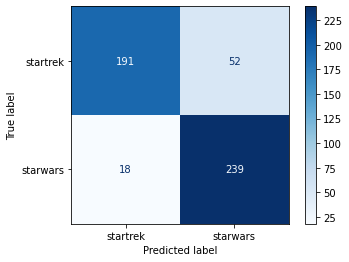

In [106]:
metrics.plot_confusion_matrix(gs, X_test, y_test, cmap = 'Blues',
                             values_format='d', display_labels=['startrek','starwars']);

I'm going to get the misclassified post for further analysis

In [50]:
y_pred = gs.predict(X_test)

In [51]:
misclassified = X_test[y_test != y_pred]

In [54]:
misclassified

1860      Kor s facial expression while going mad is gold
1323                                   No bell riots     
1292                                            Holograms
674                                                 Title
1664                    Alternate titles for each series 
                              ...                        
1006    The holodeck would have been the perfect place...
1258                            Move along home was funny
939     What do people think the untitled movies are f...
273                       Proton torpedo targeting system
1829                                   Looking for a game
Name: title, Length: 70, dtype: object

In [77]:
cvec = CountVectorizer(stop_words='english', ngram_range = (1,1))
cvec.fit(misclassified)
X = cvec.transform(misclassified)

In [81]:
cvec_df = pd.DataFrame(X.todense(), columns=cvec.get_feature_names_out())

In [107]:
cvec_df.head()

,061,1894,1981,19th,2025,2028,4659,action,afraid,agent,...,voyage,want,way,word,wordle,work,worse,wounded,yelchin,zoe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I am going to plot the bar chart of the top misclassified words

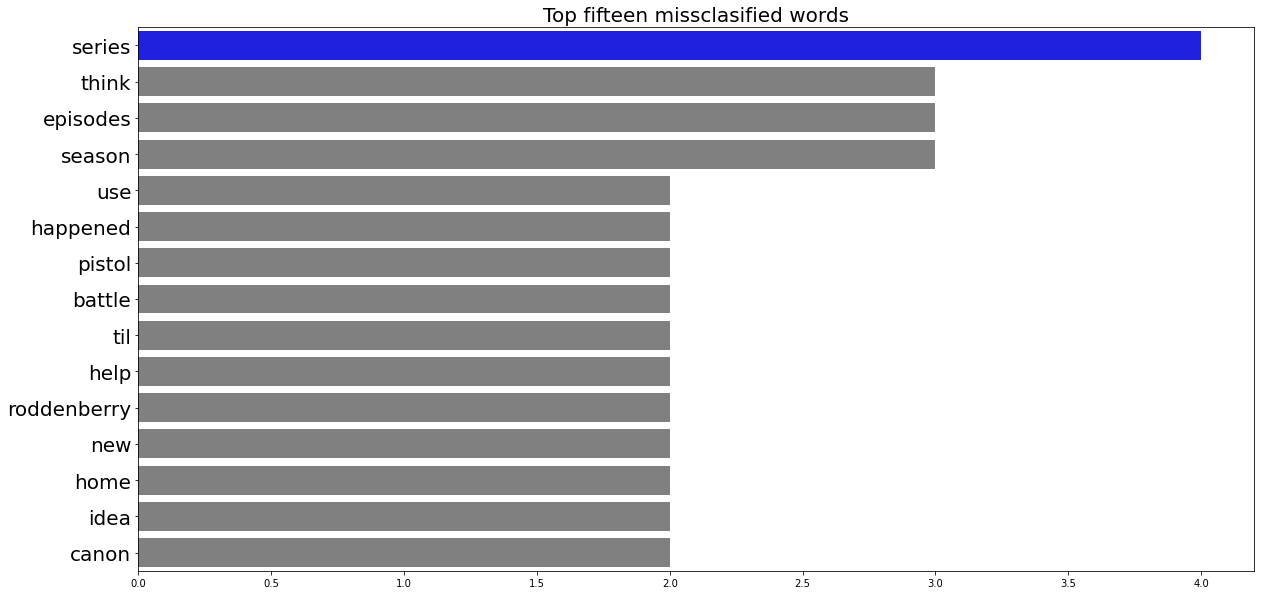

In [108]:
top_misclassified = cvec_df.sum().sort_values(ascending=False)[:15]
plt.figure(figsize=(20,10))

#set color for largest bar
colr = ['grey' if (x<max(top_misclassified)) else 'blue' for x in top_misclassified]

sns.barplot(x = top_misclassified, y = top_misclassified.index, palette = colr)
plt.yticks(fontsize= 20)

param = {'fontsize': 20,
        'fontweight': 2,
        }
plt.title('Top fifteen missclasified words', fontdict=param);